<a href="https://colab.research.google.com/github/SetiawanHadi28/UTS-Pemodelan-dan-Simulasi/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


In [2]:
@dataclass
class InventoryParams:
    days: int
    initial_stock: int
    reorder_point: int
    reorder_qty: int
    mean_demand: float
    demand_std: float
    lead_time: int
    seed: int = 42


def simulate_inventory(params: InventoryParams) -> pd.DataFrame:
    rng = np.random.default_rng(params.seed)
    stock = params.initial_stock
    backlog = 0.0
    pipeline: list[dict[str, int]] = []
    records = []

    for day in range(params.days + 1):
        deliveries = sum(o["qty"] for o in pipeline if o["arrival"] == day)
        pipeline = [o for o in pipeline if o["arrival"] > day]
        stock += deliveries

        demand = max(0, rng.normal(params.mean_demand, params.demand_std))
        demand = float(np.round(demand, 2))

        satisfied = min(stock, demand)
        stock -= satisfied
        unmet = demand - satisfied
        backlog += unmet

        order = 0
        if stock <= params.reorder_point:
            order = params.reorder_qty
            pipeline.append({"qty": params.reorder_qty, "arrival": day + params.lead_time})

        records.append(
            {
                "Hari": day,
                "Stok tersedia": np.round(stock, 2),
                "Kedatangan barang": deliveries,
                "Permintaan": demand,
                "Order ditempatkan": order,
                "Backlog": np.round(backlog, 2),
            }
        )

    return pd.DataFrame(records)


def summarize(df: pd.DataFrame) -> dict:
    served = df["Permintaan"] - df["Backlog"].diff().clip(lower=0).fillna(0)
    fill_rate = served.sum() / df["Permintaan"].sum() if df["Permintaan"].sum() else 1.0
    stockouts = (df["Stok tersedia"] == 0).sum()

    return {
        "Stok awal": df["Stok tersedia"].iloc[0],
        "Stok akhir": df["Stok tersedia"].iloc[-1],
        "Total permintaan": df["Permintaan"].sum(),
        "Tingkat pelayanan": f"{fill_rate * 100:,.2f}%",
        "Jumlah hari stockout": int(stockouts),
        "Backlog akhir": df["Backlog"].iloc[-1],
    }


def scenario_curves(days: int = 360) -> pd.DataFrame:
    day = np.arange(days)
    baseline = 200 + 0.8 * day
    step = 200 + np.where(day < 90, 0.8 * day, 0.8 * 90 + 1.8 * (day - 90))
    ramp = np.piecewise(
        day,
        [day < 60, (day >= 60) & (day < 120), day >= 120],
        [
            lambda x: 200 + 0.8 * x,
            lambda x: 200 + 0.8 * 60 + 2.5 * (x - 60),
            lambda x: 200 + 0.8 * 60 + 2.5 * (120 - 60) + 3.0 * (x - 120),
        ],
    )
    return pd.DataFrame(
        {
            "Hari": day,
            "Baseline (konstan u=1)": baseline,
            "Step (lonjakan hari 90)": step,
            "Ramp (naik bertahap 60-120)": ramp,
        }
    )


In [3]:
raw_data = pd.read_csv("train.csv", parse_dates=["date"])
raw_data.head()


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
store_id = 1
item_id = 1

history = (
    raw_data[(raw_data["store"] == store_id) & (raw_data["item"] == item_id)]
    .sort_values("date")
    .rename(columns={"sales": "demand"})
)

stats = {
    "mean_demand": history["demand"].mean(),
    "std_demand": history["demand"].std(ddof=0),
    "total_sales": history["demand"].sum(),
    "days_of_data": len(history),
}
pd.Series(stats)


,0
mean_demand,19.971522
std_demand,6.739176
total_sales,36468.000000
days_of_data,1826.000000


In [5]:
lead_time = 7
safety_factor = 1.0

mean_demand = stats["mean_demand"]
demand_std = max(stats["std_demand"], 1.0)
reorder_point = int(mean_demand * lead_time + safety_factor * demand_std * np.sqrt(lead_time))
reorder_qty = int(mean_demand * max(lead_time, 5))
initial_stock = reorder_qty

default_days = 180

params = InventoryParams(
    days=default_days,
    initial_stock=initial_stock,
    reorder_point=reorder_point,
    reorder_qty=reorder_qty,
    mean_demand=mean_demand,
    demand_std=demand_std,
    lead_time=lead_time,
    seed=42,
)
params


InventoryParams(days=180, initial_stock=139, reorder_point=157, reorder_qty=139, mean_demand=np.float64(19.971522453450163), demand_std=6.7391761080508115, lead_time=7, seed=42)

In [6]:
df = simulate_inventory(params)
df.head()

,Hari,Stok tersedia,Kedatangan barang,Permintaan,Order ditempatkan,Backlog
0,0,116.97,0,22.03,139,0.0
1,1,104.01,0,12.96,139,0.0
2,2,78.98,0,25.03,139,0.0
3,3,52.67,0,26.31,139,0.0
4,4,45.85,0,6.82,139,0.0


In [7]:
summary = summarize(df)
pd.Series(summary)


,0
Stok awal,116.97
Stok akhir,615.19
Total permintaan,3554.81
Tingkat pelayanan,100.00%
Jumlah hari stockout,0
Backlog akhir,0.0


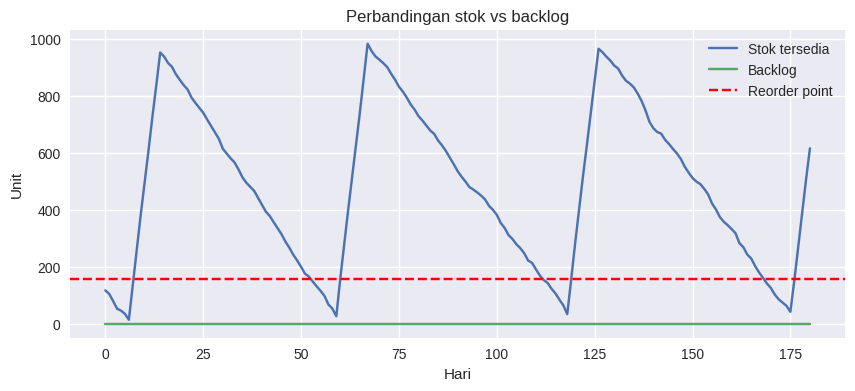

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["Hari"], df["Stok tersedia"], label="Stok tersedia")
ax.plot(df["Hari"], df["Backlog"], label="Backlog")
ax.axhline(params.reorder_point, color="red", linestyle="--", label="Reorder point")
ax.set_xlabel("Hari")
ax.set_ylabel("Unit")
ax.legend()
ax.set_title("Perbandingan stok vs backlog")
plt.show()


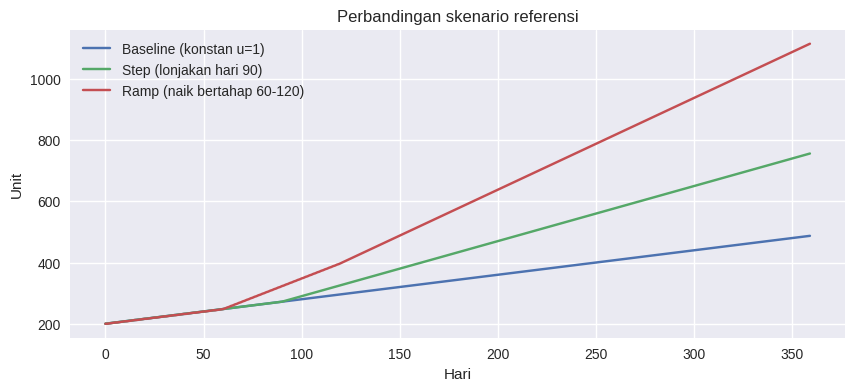

,Hari,Baseline (konstan u=1),Step (lonjakan hari 90),Ramp (naik bertahap 60-120)
0,0,200.0,200.0,200
1,1,200.8,200.8,200
2,2,201.6,201.6,201
3,3,202.4,202.4,202
4,4,203.2,203.2,203


In [9]:
scenario_df = scenario_curves(360)
fig, ax = plt.subplots(figsize=(10, 4))
for col in scenario_df.columns[1:]:
    ax.plot(scenario_df["Hari"], scenario_df[col], label=col)
ax.set_xlabel("Hari")
ax.set_ylabel("Unit")
ax.legend()
ax.set_title("Perbandingan skenario referensi")
plt.show()

scenario_df.head()
